Group Project 3: CDTs Hernon, Rennie, Owen, and Persteins

In [15]:
# import all necessary packages 

import pandas as pd
import numpy as np
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight
from sklearn.metrics import hamming_loss, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jack.hernon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10


C:\Users\jack.hernon\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.1912 - loss: 3.5202 - val_accuracy: 0.6127 - val_loss: 2.3587
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4481 - loss: 2.2279 - val_accuracy: 0.5181 - val_loss: 1.6484
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5504 - loss: 1.6286 - val_accuracy: 0.4348 - val_loss: 1.4879
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6124 - loss: 1.2652 - val_accuracy: 0.5713 - val_loss: 1.2650
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6769 - loss: 1.0453 - val_accuracy: 0.5539 - val_loss: 1.2718
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7392 - loss: 0.8337 - val_accuracy: 0.4993 - val_loss: 1.3839
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7585 - loss: 0.7293 - val_accuracy: 0.5880 - val_loss: 1.3617
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step
[1 4 4 ... 2 0 2]
[3 4 4 ... 0 1 3]
Hamming Loss: 0.42866666666666664
F1 Score: 0.4255

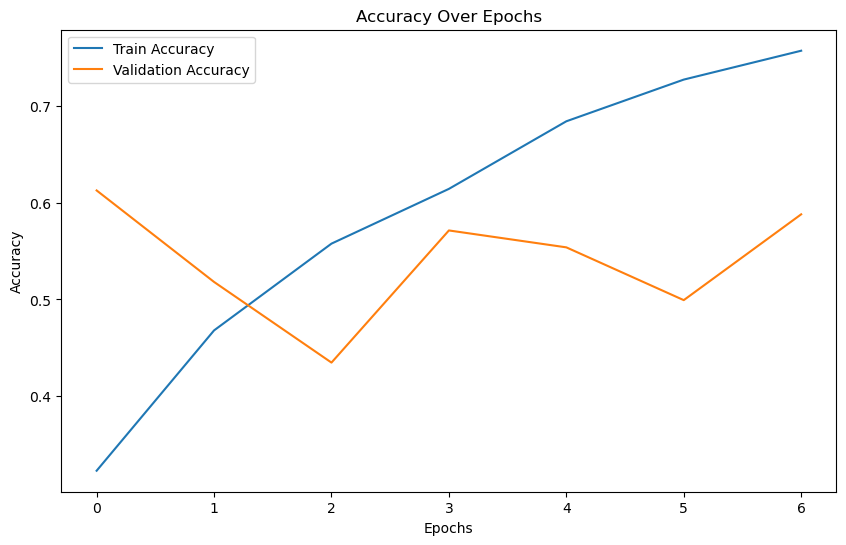

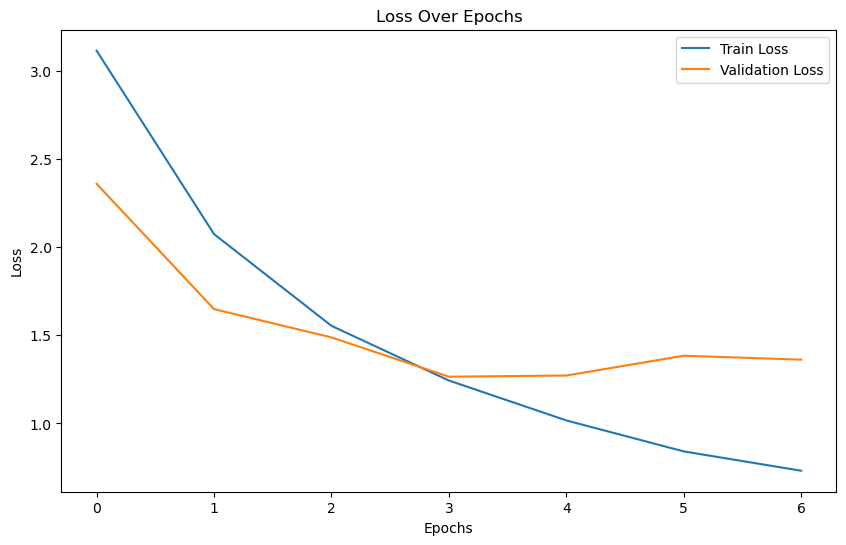

In [40]:
# step 1: import data and preprocess
# kernel size is 5, no dropout used. 

# Load the dataset
df_raw = pd.read_csv('Proj_3_files/Reviews.csv')
df = df_raw[['Score', 'Text']].copy()[:25000]

nltk.download('stopwords')
stop_words = stopwords.words('english')

# step 2: preprocess the text here. 
# Preprocess text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text, re.I | re.A)
    text = text.lower().strip()
    sent = [word for word in text.split() if word not in stop_words]
    sent = ' '.join(sent)
    return sent

df.loc[:, 'Clean_Text'] = df['Text'].apply(clean_text)  # Avoid SettingWithCopyWarning

# Tokenization and padding
max_words = 20000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Clean_Text'])
sequences = tokenizer.texts_to_sequences(df['Clean_Text'])
x = pad_sequences(sequences, maxlen=max_len)

# One-hot encode labels
y = df[['Score']].values
encoder = OneHotEncoder(sparse_output=False)  # Updated parameter
y_one_hot_encode = encoder.fit_transform(y)

# Train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y_one_hot_encode, test_size=0.3, random_state=42)

# Handle class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1)
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Load pretrained embeddings (GloVe example)
embedding_dim = 100
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        word, *vector = line.split()
        embedding_index[word] = np.array(vector, dtype="float32")

# Create embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Step 3: build the CNN and LSTM model to get results. 
# Build CNN + BiLSTM model
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len,
              trainable=True),  # Trainable embedding layer without pretrained weights
    Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer='l2'),
   # Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(128, activation='relu', kernel_regularizer='l2'),
  #  Dropout(0.5),
    Dense(5, activation='softmax')  # For multiclass classification
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# Evaluate the model
y_pred_prob = model.predict(x_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)
print(y_pred)
print(y_true)

# Step 4: calculate metrics on our model and analyze misclassifications. 
# Calculate metrics
hamming = hamming_loss(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Hamming Loss: {hamming}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:")
print(conf_matrix)

# Visualize misclassified samples
misclassified_idx = np.where(y_true != y_pred)[0][:5]
for idx in misclassified_idx:
    raw_sentence = [i for i in tokenizer.sequences_to_texts([x_val[idx]])[0].split(' ') if i != 'UNK']
    print(f"Predicted: {y_pred[idx]}, Actual: {y_true[idx]}, Sentence: {raw_sentence}")

# Plot training vs validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jack.hernon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10


C:\Users\jack.hernon\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.1647 - loss: 3.4764 - val_accuracy: 0.5753 - val_loss: 2.1816
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5258 - loss: 2.0730 - val_accuracy: 0.5012 - val_loss: 1.6758
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6039 - loss: 1.5020 - val_accuracy: 0.4553 - val_loss: 1.4713
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6009 - loss: 1.2510 - val_accuracy: 0.5475 - val_loss: 1.2957
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.6479 - loss: 1.0484 - val_accuracy: 0.3929 - val_loss: 1.4544
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.6477 - loss: 0.9351 - val_accuracy: 0.5264 - val_loss: 1.3612
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7117 - loss: 0.8407 - val_accuracy: 0.5115 - val_loss: 1.4854
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step
Hamming Loss: 0.45253333333333334
F1 Score: 0.39570016627290017
Precision: 0.40172422

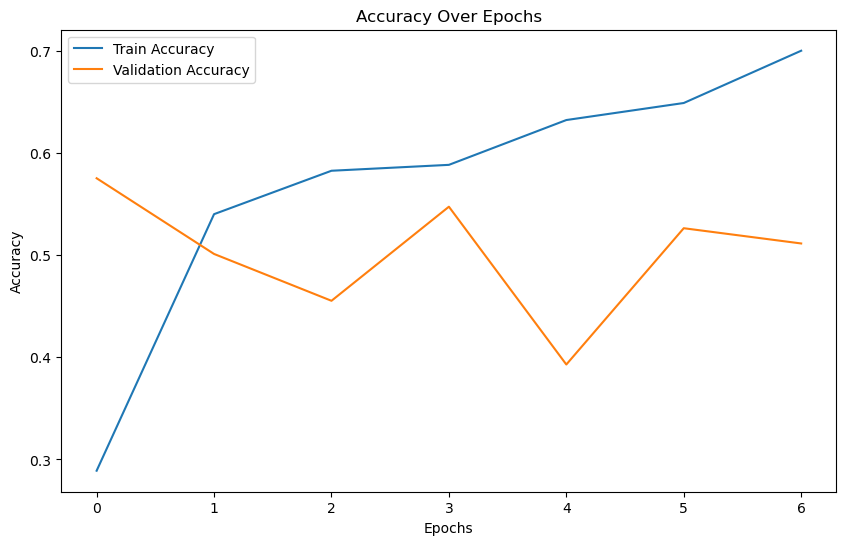

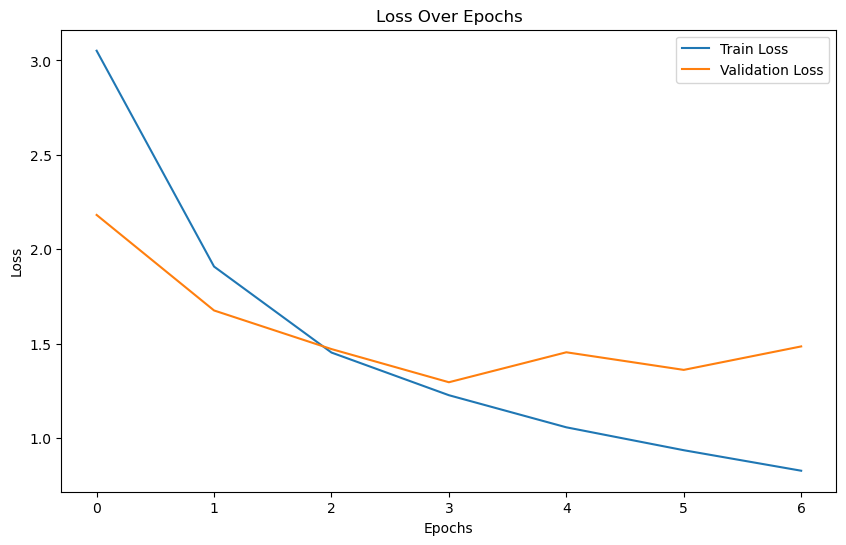

In [46]:
# kernel is 7, no dropout

# Load the dataset
df_raw = pd.read_csv('Proj_3_files/Reviews.csv')
df = df_raw[['Score', 'Text']].copy()[:25000]

nltk.download('stopwords')
stop_words = stopwords.words('english')

# Preprocess text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text, re.I | re.A)
    text = text.lower().strip()
    sent = [word for word in text.split() if word not in stop_words]
    sent = ' '.join(sent)
    return sent

df.loc[:, 'Clean_Text'] = df['Text'].apply(clean_text)  # Avoid SettingWithCopyWarning

# Tokenization and padding
max_words = 20000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Clean_Text'])
sequences = tokenizer.texts_to_sequences(df['Clean_Text'])
x = pad_sequences(sequences, maxlen=max_len)

# One-hot encode labels
y = df[['Score']].values
encoder = OneHotEncoder(sparse_output=False)  # Updated parameter
y_one_hot_encode = encoder.fit_transform(y)

# Train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y_one_hot_encode, test_size=0.3, random_state=42)

# Handle class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1)
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Load pretrained embeddings (GloVe example)
embedding_dim = 100
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        word, *vector = line.split()
        embedding_index[word] = np.array(vector, dtype="float32")

# Create embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build CNN + BiLSTM model
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len,
              trainable=True),  # Trainable embedding layer without pretrained weights
    Conv1D(filters=128, kernel_size=7, activation='relu', kernel_regularizer='l2'),
    #Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    #Dropout(0.5),
    Dense(5, activation='softmax')  # For multiclass classification
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# Evaluate the model
y_pred_prob = model.predict(x_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate metrics
hamming = hamming_loss(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Hamming Loss: {hamming}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:")
print(conf_matrix)

# Visualize misclassified samples
misclassified_idx = np.where(y_true != y_pred)[0][:5]
for idx in misclassified_idx:
    raw_sentence = [i for i in tokenizer.sequences_to_texts([x_val[idx]])[0].split(' ') if i != 'UNK']
    print(f"Predicted: {y_pred[idx]}, Actual: {y_true[idx]}, Sentence: {raw_sentence}")

# Plot training vs validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jack.hernon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10


C:\Users\jack.hernon\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.1898 - loss: 3.5371 - val_accuracy: 0.5012 - val_loss: 2.4930
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5214 - loss: 2.2752 - val_accuracy: 0.5277 - val_loss: 1.6355
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5833 - loss: 1.5993 - val_accuracy: 0.4245 - val_loss: 1.5353
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.6327 - loss: 1.2414 - val_accuracy: 0.5881 - val_loss: 1.2214
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7041 - loss: 0.9903 - val_accuracy: 0.6137 - val_loss: 1.1691
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.7549 - loss: 0.8055 - val_accuracy: 0.5349 - val_loss: 1.3524
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.7665 - loss: 0.7101 - val_accuracy: 0.5336 - val_loss: 1.4072
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7870 - loss: 0.6059 - val_accuracy: 0.4847 - val_loss: 1.6196
235

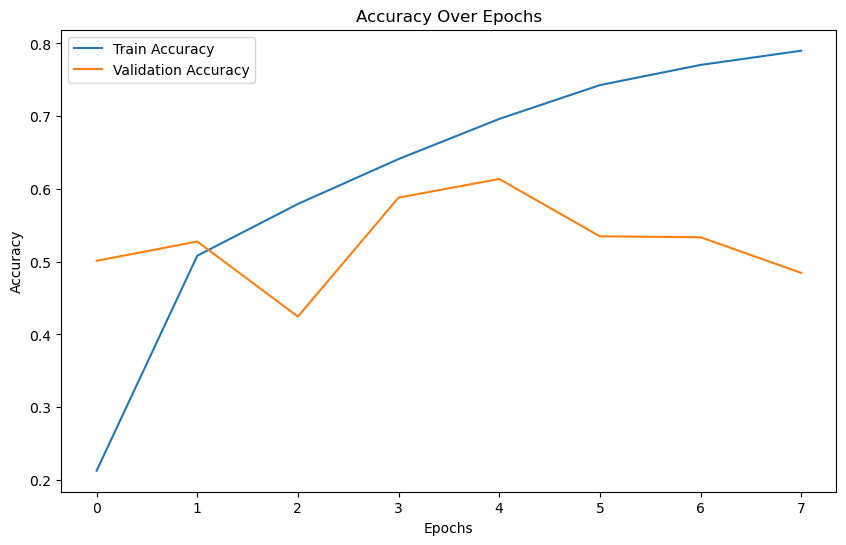

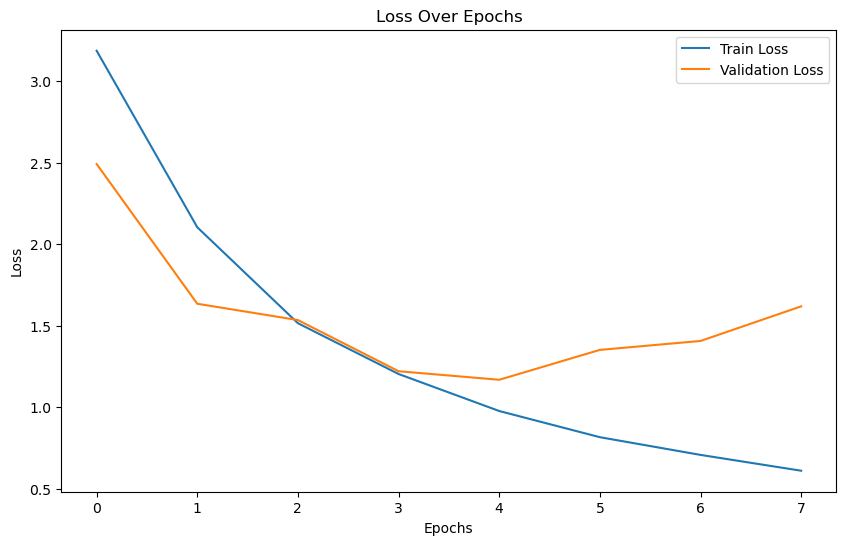

In [52]:
# kernel is 3, no dropout

# Load the dataset
df_raw = pd.read_csv('Proj_3_files/Reviews.csv')
df = df_raw[['Score', 'Text']].copy()[:25000]

nltk.download('stopwords')
stop_words = stopwords.words('english')

# Preprocess text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text, re.I | re.A)
    text = text.lower().strip()
    sent = [word for word in text.split() if word not in stop_words]
    sent = ' '.join(sent)
    return sent

df.loc[:, 'Clean_Text'] = df['Text'].apply(clean_text)  # Avoid SettingWithCopyWarning

# Tokenization and padding
max_words = 20000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Clean_Text'])
sequences = tokenizer.texts_to_sequences(df['Clean_Text'])
x = pad_sequences(sequences, maxlen=max_len)

# One-hot encode labels
y = df[['Score']].values
encoder = OneHotEncoder(sparse_output=False)  # Updated parameter
y_one_hot_encode = encoder.fit_transform(y)

# Train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y_one_hot_encode, test_size=0.3, random_state=42)

# Handle class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1)
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Load pretrained embeddings (GloVe example)
embedding_dim = 100
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        word, *vector = line.split()
        embedding_index[word] = np.array(vector, dtype="float32")

# Create embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build CNN + BiLSTM model
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len,
              trainable=True),  # Trainable embedding layer without pretrained weights
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer='l2'),
   # Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(128, activation='relu', kernel_regularizer='l2'),
 #   Dropout(0.5),
    Dense(5, activation='softmax')  # For multiclass classification
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# Evaluate the model
y_pred_prob = model.predict(x_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate metrics
hamming = hamming_loss(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Hamming Loss: {hamming}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:")
print(conf_matrix)

# Visualize misclassified samples
misclassified_idx = np.where(y_true != y_pred)[0][:5]
for idx in misclassified_idx:
    raw_sentence = [i for i in tokenizer.sequences_to_texts([x_val[idx]])[0].split(' ') if i != 'UNK']
    print(f"Predicted: {y_pred[idx]}, Actual: {y_true[idx]}, Sentence: {raw_sentence}")

# Plot training vs validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jack.hernon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10


C:\Users\jack.hernon\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.1977 - loss: 3.5124 - val_accuracy: 0.1013 - val_loss: 2.4211
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.3060 - loss: 2.2557 - val_accuracy: 0.4864 - val_loss: 1.8223
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5077 - loss: 1.7544 - val_accuracy: 0.5140 - val_loss: 1.4199
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5205 - loss: 1.4048 - val_accuracy: 0.5520 - val_loss: 1.2125
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5647 - loss: 1.2303 - val_accuracy: 0.5721 - val_loss: 1.1897
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5655 - loss: 1.1031 - val_accuracy: 0.4412 - val_loss: 1.4026
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6009 - loss: 1.0460 - val_accuracy: 0.5236 - val_loss: 1.3441
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6332 - loss: 0.9585 - val_accuracy: 0.4843 - val_loss: 1.3978
235

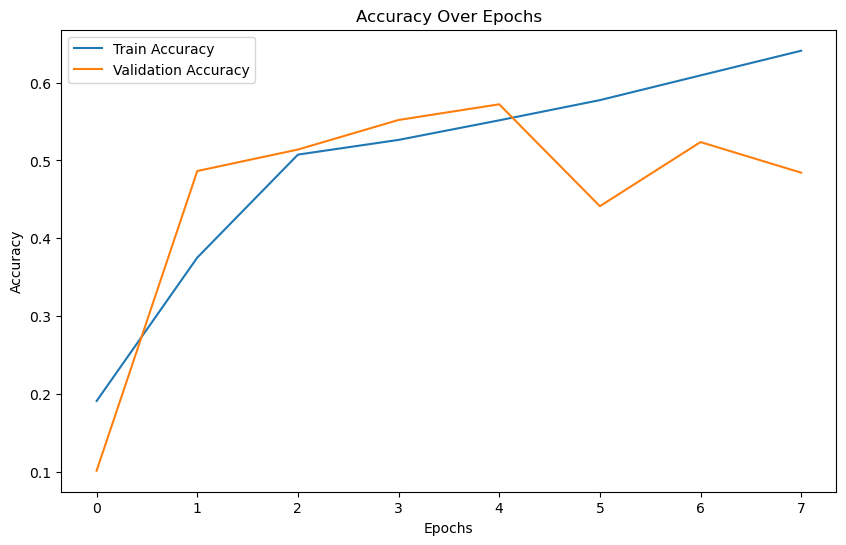

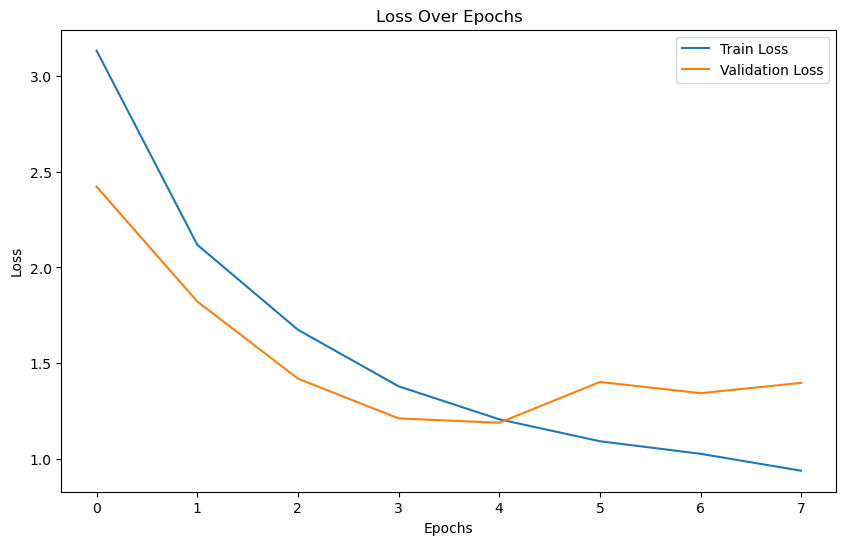

In [53]:
# kernel is 5,  dropout

# Load the dataset
df_raw = pd.read_csv('Proj_3_files/Reviews.csv')
df = df_raw[['Score', 'Text']].copy()[:25000]

nltk.download('stopwords')
stop_words = stopwords.words('english')

# Preprocess text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text, re.I | re.A)
    text = text.lower().strip()
    sent = [word for word in text.split() if word not in stop_words]
    sent = ' '.join(sent)
    return sent

df.loc[:, 'Clean_Text'] = df['Text'].apply(clean_text)  # Avoid SettingWithCopyWarning

# Tokenization and padding
max_words = 20000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Clean_Text'])
sequences = tokenizer.texts_to_sequences(df['Clean_Text'])
x = pad_sequences(sequences, maxlen=max_len)

# One-hot encode labels
y = df[['Score']].values
encoder = OneHotEncoder(sparse_output=False)  # Updated parameter
y_one_hot_encode = encoder.fit_transform(y)

# Train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y_one_hot_encode, test_size=0.3, random_state=42)

# Handle class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1)
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Load pretrained embeddings (GloVe example)
embedding_dim = 100
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        word, *vector = line.split()
        embedding_index[word] = np.array(vector, dtype="float32")

# Create embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build CNN + BiLSTM model
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len,
              trainable=True),  # Trainable embedding layer without pretrained weights
    Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # For multiclass classification
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# Evaluate the model
y_pred_prob = model.predict(x_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate metrics
hamming = hamming_loss(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Hamming Loss: {hamming}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:")
print(conf_matrix)

# Visualize misclassified samples
misclassified_idx = np.where(y_true != y_pred)[0][:5]
for idx in misclassified_idx:
    raw_sentence = [i for i in tokenizer.sequences_to_texts([x_val[idx]])[0].split(' ') if i != 'UNK']
    print(f"Predicted: {y_pred[idx]}, Actual: {y_true[idx]}, Sentence: {raw_sentence}")

# Plot training vs validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jack.hernon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10


C:\Users\jack.hernon\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.2517 - loss: 3.2895 - val_accuracy: 0.5685 - val_loss: 2.3435
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.5464 - loss: 2.1813 - val_accuracy: 0.5797 - val_loss: 1.4924
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.5701 - loss: 1.5371 - val_accuracy: 0.5753 - val_loss: 1.2931
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.6083 - loss: 1.2273 - val_accuracy: 0.4947 - val_loss: 1.3831
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.6054 - loss: 1.1060 - val_accuracy: 0.5340 - val_loss: 1.3046
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6687 - loss: 0.9206 - val_accuracy: 0.5744 - val_loss: 1.3083
235/235 ━━━━━━━━━━━━━━━━━━━━ 47s 196ms/step
Hamming Loss: 0.4246666666666667
F1 Score: 0.372841657305703
Precision: 0.38010193136128223
Recall: 0.38570079757780895
Confusion Matrix:
[[ 334  132  159   23   34]
 [ 131  109  142   30   44]
 [  64  121  207

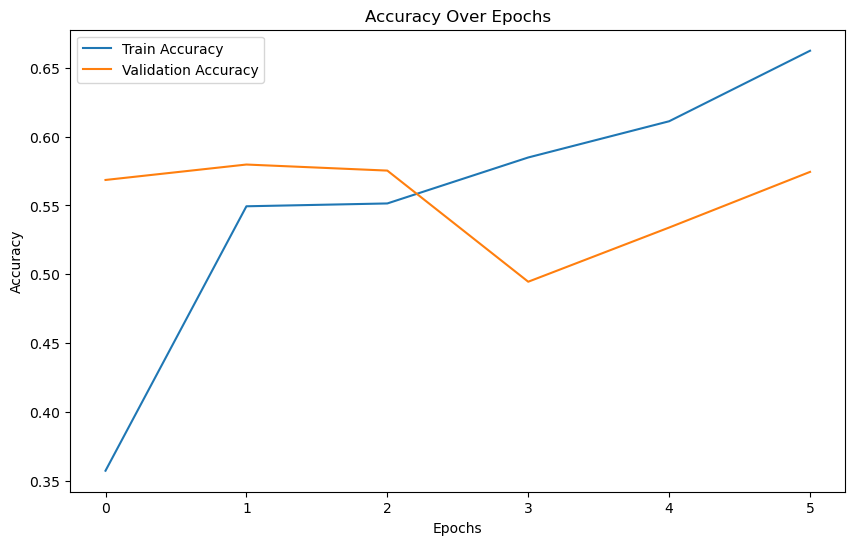

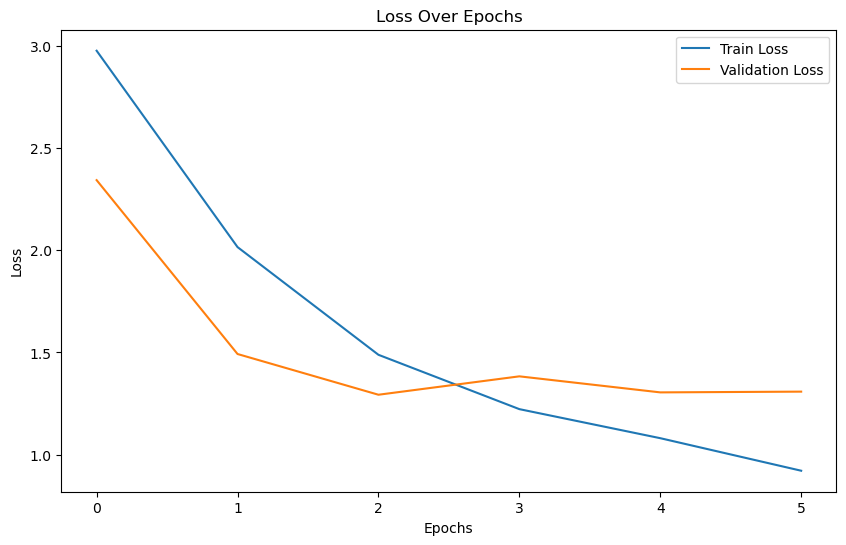

In [54]:
# kernel is 5, no dropout, filters are 64

# Load the dataset
df_raw = pd.read_csv('Proj_3_files/Reviews.csv')
df = df_raw[['Score', 'Text']].copy()[:25000]

nltk.download('stopwords')
stop_words = stopwords.words('english')

# Preprocess text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text, re.I | re.A)
    text = text.lower().strip()
    sent = [word for word in text.split() if word not in stop_words]
    sent = ' '.join(sent)
    return sent

df.loc[:, 'Clean_Text'] = df['Text'].apply(clean_text)  # Avoid SettingWithCopyWarning

# Tokenization and padding
max_words = 20000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Clean_Text'])
sequences = tokenizer.texts_to_sequences(df['Clean_Text'])
x = pad_sequences(sequences, maxlen=max_len)

# One-hot encode labels
y = df[['Score']].values
encoder = OneHotEncoder(sparse_output=False)  # Updated parameter
y_one_hot_encode = encoder.fit_transform(y)

# Train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y_one_hot_encode, test_size=0.3, random_state=42)

# Handle class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1)
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Load pretrained embeddings (GloVe example)
embedding_dim = 100
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        word, *vector = line.split()
        embedding_index[word] = np.array(vector, dtype="float32")

# Create embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build CNN + BiLSTM model
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len,
              trainable=True),  # Trainable embedding layer without pretrained weights
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer='l2'),
    #Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    #Dropout(0.5),
    Dense(5, activation='softmax')  # For multiclass classification
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# Evaluate the model
y_pred_prob = model.predict(x_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate metrics
hamming = hamming_loss(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Hamming Loss: {hamming}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:")
print(conf_matrix)

# Visualize misclassified samples
misclassified_idx = np.where(y_true != y_pred)[0][:5]
for idx in misclassified_idx:
    raw_sentence = [i for i in tokenizer.sequences_to_texts([x_val[idx]])[0].split(' ') if i != 'UNK']
    print(f"Predicted: {y_pred[idx]}, Actual: {y_true[idx]}, Sentence: {raw_sentence}")

# Plot training vs validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jack.hernon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10


C:\Users\jack.hernon\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.0814 - loss: 3.6760 - val_accuracy: 0.5551 - val_loss: 2.3205
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.4730 - loss: 2.1822 - val_accuracy: 0.4276 - val_loss: 1.8076
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.5352 - loss: 1.7140 - val_accuracy: 0.5895 - val_loss: 1.2769
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.6053 - loss: 1.3848 - val_accuracy: 0.5489 - val_loss: 1.2788
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6489 - loss: 1.0687 - val_accuracy: 0.5673 - val_loss: 1.2338
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.7120 - loss: 0.8558 - val_accuracy: 0.5136 - val_loss: 1.3579
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.7395 - loss: 0.7270 - val_accuracy: 0.5479 - val_loss: 1.4518
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.7726 - loss: 0.6388 - val_accuracy: 0.5291 - val_loss: 1.5034


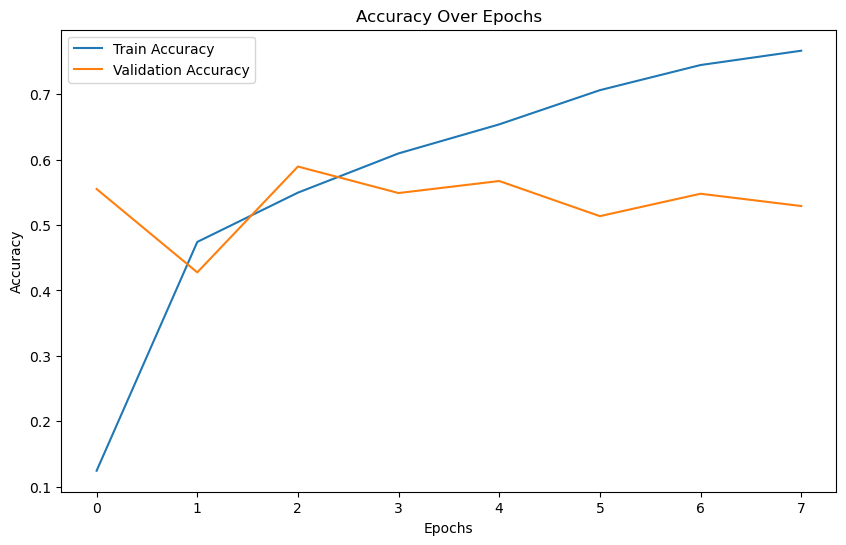

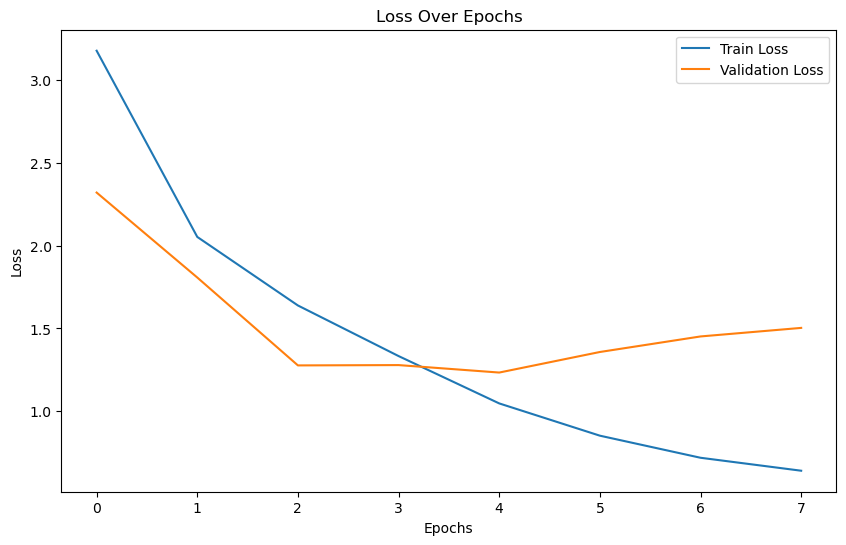

In [55]:
# kernel is 5, no dropout, filters 256

# Load the dataset
df_raw = pd.read_csv('Proj_3_files/Reviews.csv')
df = df_raw[['Score', 'Text']].copy()[:25000]

nltk.download('stopwords')
stop_words = stopwords.words('english')

# Preprocess text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text, re.I | re.A)
    text = text.lower().strip()
    sent = [word for word in text.split() if word not in stop_words]
    sent = ' '.join(sent)
    return sent

df.loc[:, 'Clean_Text'] = df['Text'].apply(clean_text)  # Avoid SettingWithCopyWarning

# Tokenization and padding
max_words = 20000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Clean_Text'])
sequences = tokenizer.texts_to_sequences(df['Clean_Text'])
x = pad_sequences(sequences, maxlen=max_len)

# One-hot encode labels
y = df[['Score']].values
encoder = OneHotEncoder(sparse_output=False)  # Updated parameter
y_one_hot_encode = encoder.fit_transform(y)

# Train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y_one_hot_encode, test_size=0.3, random_state=42)

# Handle class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1)
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Load pretrained embeddings (GloVe example)
embedding_dim = 100
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        word, *vector = line.split()
        embedding_index[word] = np.array(vector, dtype="float32")

# Create embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build CNN + BiLSTM model
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len,
              trainable=True),  # Trainable embedding layer without pretrained weights
    Conv1D(filters=256, kernel_size=5, activation='relu', kernel_regularizer='l2'),
    #Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    #Dropout(0.5),
    Dense(5, activation='softmax')  # For multiclass classification
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# Evaluate the model
y_pred_prob = model.predict(x_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate metrics
hamming = hamming_loss(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Hamming Loss: {hamming}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:")
print(conf_matrix)

# Visualize misclassified samples
misclassified_idx = np.where(y_true != y_pred)[0][:5]
for idx in misclassified_idx:
    raw_sentence = [i for i in tokenizer.sequences_to_texts([x_val[idx]])[0].split(' ') if i != 'UNK']
    print(f"Predicted: {y_pred[idx]}, Actual: {y_true[idx]}, Sentence: {raw_sentence}")

# Plot training vs validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()